In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Read dataset1:

In [2]:
points = pd.read_csv("dataset1.txt", delimiter=' ', header=None).values

Visualize the data:

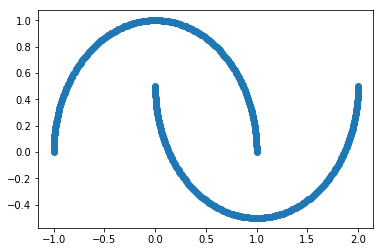

In [3]:
plt.plot(points[:, 0], points[:, 1], 'o')

#### a. Fit K-means and plot the clusters :

In [4]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

for n_clusters in range(2,11):
    kmeans = KMeans(n_clusters=n_clusters,random_state=0).fit(points)
    sil_coeff = silhouette_score(points, kmeans.labels_, metric='euclidean')
    print("For n_clusters={}, The Silhouette Coefficient is {}".format(n_clusters, sil_coeff))

For n_clusters=2, The Silhouette Coefficient is 0.49196929787574434
For n_clusters=3, The Silhouette Coefficient is 0.43295416862020586
For n_clusters=4, The Silhouette Coefficient is 0.46455038486899547
For n_clusters=5, The Silhouette Coefficient is 0.49524312179203234
For n_clusters=6, The Silhouette Coefficient is 0.5231531284487236
For n_clusters=7, The Silhouette Coefficient is 0.5379793756173212
For n_clusters=8, The Silhouette Coefficient is 0.5458008117512138
For n_clusters=9, The Silhouette Coefficient is 0.5430515097714561
For n_clusters=10, The Silhouette Coefficient is 0.5417626503366533


As Silhouette Coefficient is more for for k=8, set n_clusters=8

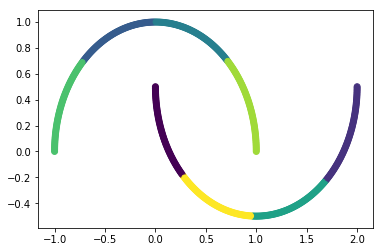

In [5]:
kmeans = KMeans(n_clusters=8,random_state=0).fit(points)
plt.scatter(points[:, 0], points[:, 1], c=kmeans.labels_, cmap='viridis')

But with the visualization we can see two clusters in it, so lets try with n_clusters=2

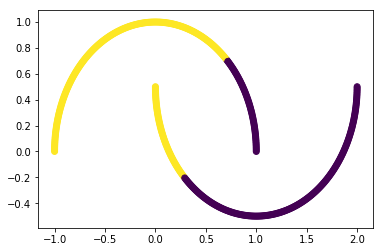

In [6]:
kmeans = KMeans(n_clusters=2,random_state=0).fit(points)
plt.scatter(points[:, 0], points[:, 1], c=kmeans.labels_, cmap='viridis')

Though for human eye, we can see two shapes as two different clusters, K-Means fails to detect them as separate clusters.

#### b. DBSCAN implementation:

In [7]:
from sklearn.neighbors import KDTree # KDTree is used for spatial indexing

class CUSTOM_DBSCAN():
    """
    Custom DBSCAN algorithm implementation
    """
    
    def __init__(self, database):
        """
        Initialize by passing database that are to be labeled
        """
        self.database = database
        self.tree = KDTree(database, leaf_size=5) #KD-Tree for indexing
        
    def get_kth_neighbour_dist(self, k=4):
        """
        Return the distances of k-th neighbour for all points
        This is useful to estimate the eps with min_pts as k
        """       
        kth_neighbour_dist = []
        for index in range(0, len(self.database)):
            point = np.reshape(self.database[index, :], (1, -1))
            dist, ind = self.tree.query(point, k)
            kth_neighbour_dist.append(dist[0,k-1])
            
        return kth_neighbour_dist

    def label_data(self, eps=0.5, min_pts=5):
        """
        eps : the radius to check for density reachability
        minPts : the minimum number of points to be in the eps radius to define a core point

        Returns:
        labels for the all points
        -1 : Noise
        > 0 as cluster index 
        0 is unlabeled
        """
        self.eps = eps
        self.min_pts = min_pts
        
        # Initialize labels for the points as unclassified
        labels = [0]*len(self.database)

        # Cluster index 
        cluster_id = 1

        # Iterate over all the points in DB add to clusters
        for index in range(0, len(self.database)):
            point = self.database[index, :]

            # If point is already labled then skip it
            if not (labels[index] == 0):
                continue;

            # get neighbourgood with in eps radius
            neighbours = self.do_range_query(index)

            # If point has less neighbours then label it as noise
            if len(neighbours) < self.min_pts:
                labels[index] = -1
            # Else grow the cluster based on this point as core point
            else:
                self.expand_cluster(cluster_id, neighbours, labels)
                labels[index] = cluster_id
                cluster_id += 1

        return labels

    def expand_cluster(self, cluster_id, neighbours, labels):
        '''
        Expand cluster by adding all density connected points with root as database[index]
        '''
        i = 0
        while i < len(neighbours):
            n_index = neighbours[i]

            # If neigbourhood point is labled as noise as before, then add it to this cluster
            if labels[n_index] == -1:
                labels[n_index] = cluster_id
            # If point is not labeled already, then get the neighbourhood of that and grow it
            elif labels[n_index] == 0:
                labels[n_index] = cluster_id

                n_neighbours = self.do_range_query(n_index)
                # if neighbourhood of neighbour is more than min_pts then make it as core point and grow cluster
                if len(n_neighbours) >= self.min_pts:
                    neighbours = np.concatenate((neighbours, n_neighbours))

            i += 1 # visit next neighbour

    def do_range_query(self, index):
        '''
        Get the neighbourhood of point database[index] with in eps radius
        '''
        point = np.reshape(self.database[index, :], (1, -1))
        neighbours = self.tree.query_radius(point, self.eps)[0]
        return np.delete(neighbours, np.where(neighbours == index))

Get the 4-dist plot to estimate eps for min_pts=4

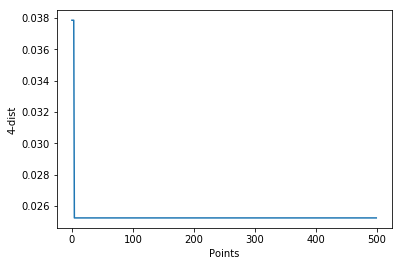

In [8]:
custom_dbscan = CUSTOM_DBSCAN(points)
fourth_neighbour_dist = custom_dbscan.get_kth_neighbour_dist(k=4)
plt.plot(range(0, len(points)), sorted(fourth_neighbour_dist, reverse=True))
plt.xlabel("Points"); plt.ylabel("4-dist")
plt.show()

From the above plot, we can see that 4th neighbour is very near to all the points, so lets take very low eps=0.2 and set min_pts as 4.

Plot the clusters with custom implentation:

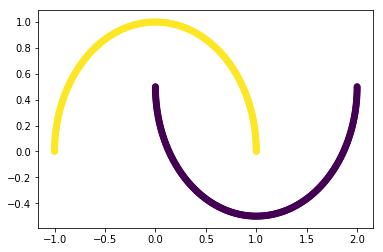

In [9]:
dbscan_labels = custom_dbscan.label_data(eps=0.2, min_pts=4)
plt.scatter(points[:, 0], points[:, 1], c=dbscan_labels, cmap='viridis')

Plot the clusters with library implementation:

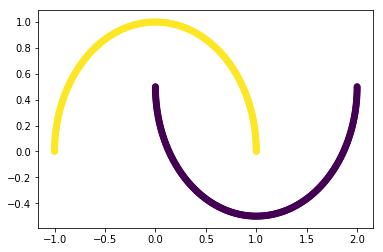

In [10]:
from sklearn.cluster import DBSCAN
dbscan = DBSCAN(eps=0.2, min_samples=4).fit(points)
plt.scatter(points[:, 0], points[:, 1], c=dbscan.labels_, cmap='viridis')

#### c. Observations:

1) From the plots we can say DBSCAN can detect non globular shapes where as K-Means couldn't do. 

Reason : In K-Means we try to minimize the labeling error by minimizing the distance between centroid and associated points, this logic yeilds glob like shapes for the clusters with centroids in middle. Where as in DBSCAN, we proceed towards the all reachable points with in eps distance and expand cluster. This propagation can take in any direction as long as we have enough points, so clusters can take any shape.

2) K-Means algorithm takes number of clusters as parameter but DBSCAN detects the clusters based on denisty parameters (eps and min_pts) 

#### d. Check for dataset-2

In [11]:
points2 = pd.read_csv("dataset2.txt", header=None, delimiter=' ').values

Visualize the data:

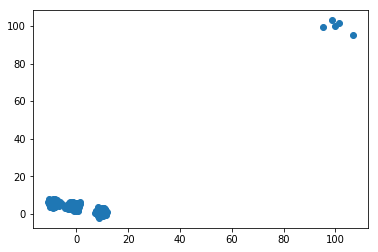

In [12]:
plt.plot(points2[:, 0], points2[:, 1], 'o')

Fit K-Means, based on visualization we can check for 2-5 clusters and take the best one that explains :

In [13]:
for n_clusters in range(2,5):
    kmeans = KMeans(n_clusters=n_clusters,random_state=0).fit(points2)
    sil_coeff = silhouette_score(points2, kmeans.labels_, metric='euclidean')
    print("For n_clusters={}, The Silhouette Coefficient is {}".format(n_clusters, sil_coeff))

For n_clusters=2, The Silhouette Coefficient is 0.9353315859487462
For n_clusters=3, The Silhouette Coefficient is 0.7464778909855324
For n_clusters=4, The Silhouette Coefficient is 0.7958194864172932


Even though 'Silhouette Coefficient' is more for k=2, from the visualization we can see 4 clusters, so lets fit n_clusters to 4 

20.4 ms ± 9.86 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


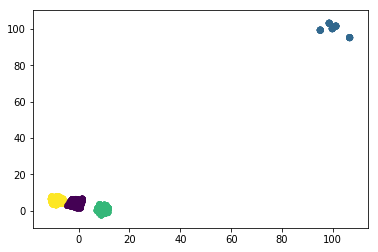

In [16]:
%%timeit -n 1
kmeans = KMeans(n_clusters=4,random_state=0).fit(points2)
plt.scatter(points2[:, 0], points2[:, 1], c=kmeans.labels_, cmap='viridis')

Now, fit DBSCAN and plot the clusters:

To get the best eps and min_pts, plot the 4-dist graph for all points and take the threshold value as eps

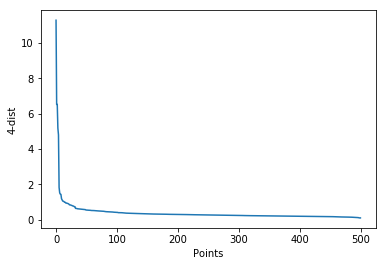

In [39]:
custom_dbscan1 = CUSTOM_DBSCAN(points2)
fourth_neighbour_dist = custom_dbscan1.get_kth_neighbour_dist(k=4)
plt.plot(range(0, len(points2)), sorted(fourth_neighbour_dist, reverse=True))
plt.xlabel("Points"); plt.ylabel("4-dist")
plt.show()

Plot the clusters with eps=1.5 and min_pts=4

116 ms ± 33.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


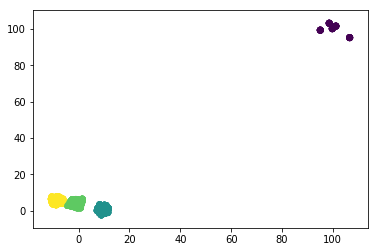

In [71]:
%%timeit -n 1
dbscan_labels1 = custom_dbscan1.label_data(eps=1.5, min_pts=4)
plt.scatter(points2[:, 0], points2[:, 1], c=dbscan_labels1, cmap='viridis')

In [54]:
dbscan_labels_str = [ "Noise" if x == -1 else "Cluster "+str(x) for x in dbscan_labels1]
dbscan_labels_str.count("Noise")

5

#### Observations for dataset-2:

For second dataset,both K-means and DBSCAN are able to label the data correctly. But we can see their limitations :

- In K-means, we need to know the number of clusters before running alogrithm which is hard when we can't visualize the data. For dataset-2, we got best silhoutte coefficient for k=2, but as we can visualize the data we set n_clusters=4, but its not always the case with high-dimensional data.

- For DBSCAN, we followed a hueristic to set eps and min-pts. This may not work always when clusters have non-uniform denisty as we are applying same eps and min-pts for all the clusters. In dataset2, the top corner points has less density than bottom clusters, so DBSCAN classified them as Noise, where as in K-Means it labeled them also as clusters.

Though the custom implementation of DBSCAN took more time, with better indexing it'll come close to K-Means in efficiency for high-dimensional data.